In [1]:
# Development setup - run this cell after making changes to src files
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from src.linear_regression import LinearRegression

from src.utils import geometric_adstock, saturation

# Data simulation
This DGP will be really similar to the [pymc-marketing](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) one.

$$
Y_t= \mu + X_{1t} \beta_1 + X_{2y} \beta_2 + \sum^{C}_{c=1} M_c \gamma_{ct} + \epsilon
$$
where $Y_t$ represent weekly sales, $\mu$ is the intercept, $\beta_1,...,\beta_3$ are coefficients associated to media tactics, $\gamma$ is associated to the control variables, and $\epsilon$ is an error term that we assume $N(0,1)$. Now let's simulate the data.

In [2]:
seed = 73815

# Option 1: Use global np.random (simpler)
np.random.seed(seed)

# Option 2: Use generator consistently (recommended)
rng = np.random.default_rng(seed=seed)

# data range
min_date = pd.to_datetime('1997-01-01')
max_date = pd.to_datetime('1999-12-31')

df = pd.DataFrame(
    data = {"date_week" : pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

df['day_of_year'] = df['date_week'].dt.dayofyear

n = df.shape[0]

x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

df['x1_sat_media_cost'] = rng.normal(loc = 1, scale = 0.5, size = n)
df['x2_sat_media_cost'] = rng.normal(loc = 1, scale = 0.5, size = n)

Now for calculating the geometric adstock we follow this equation:
$$
Adstock_t = Media_t + α * Adstock_{t-1}
$$

In [4]:
# alpha parameters were randomly selected

df['x1_adstocked'] = geometric_adstock(x1, 0.4)
df['x2_adstocked'] = geometric_adstock(x2, 0.2)

For calculating saturation we follow:

$$
saturation = \frac{1-e^{-\lambda x}}{1+e^{-\lambda x}}
$$
where x is the adstocked variable and $\lambda$ the parameter that defines how strong saturation will be.

In [5]:
df['x1_sat'] = saturation(df['x1_adstocked'], 2)
df['x2_sat'] = saturation(df['x2_adstocked'], 5)

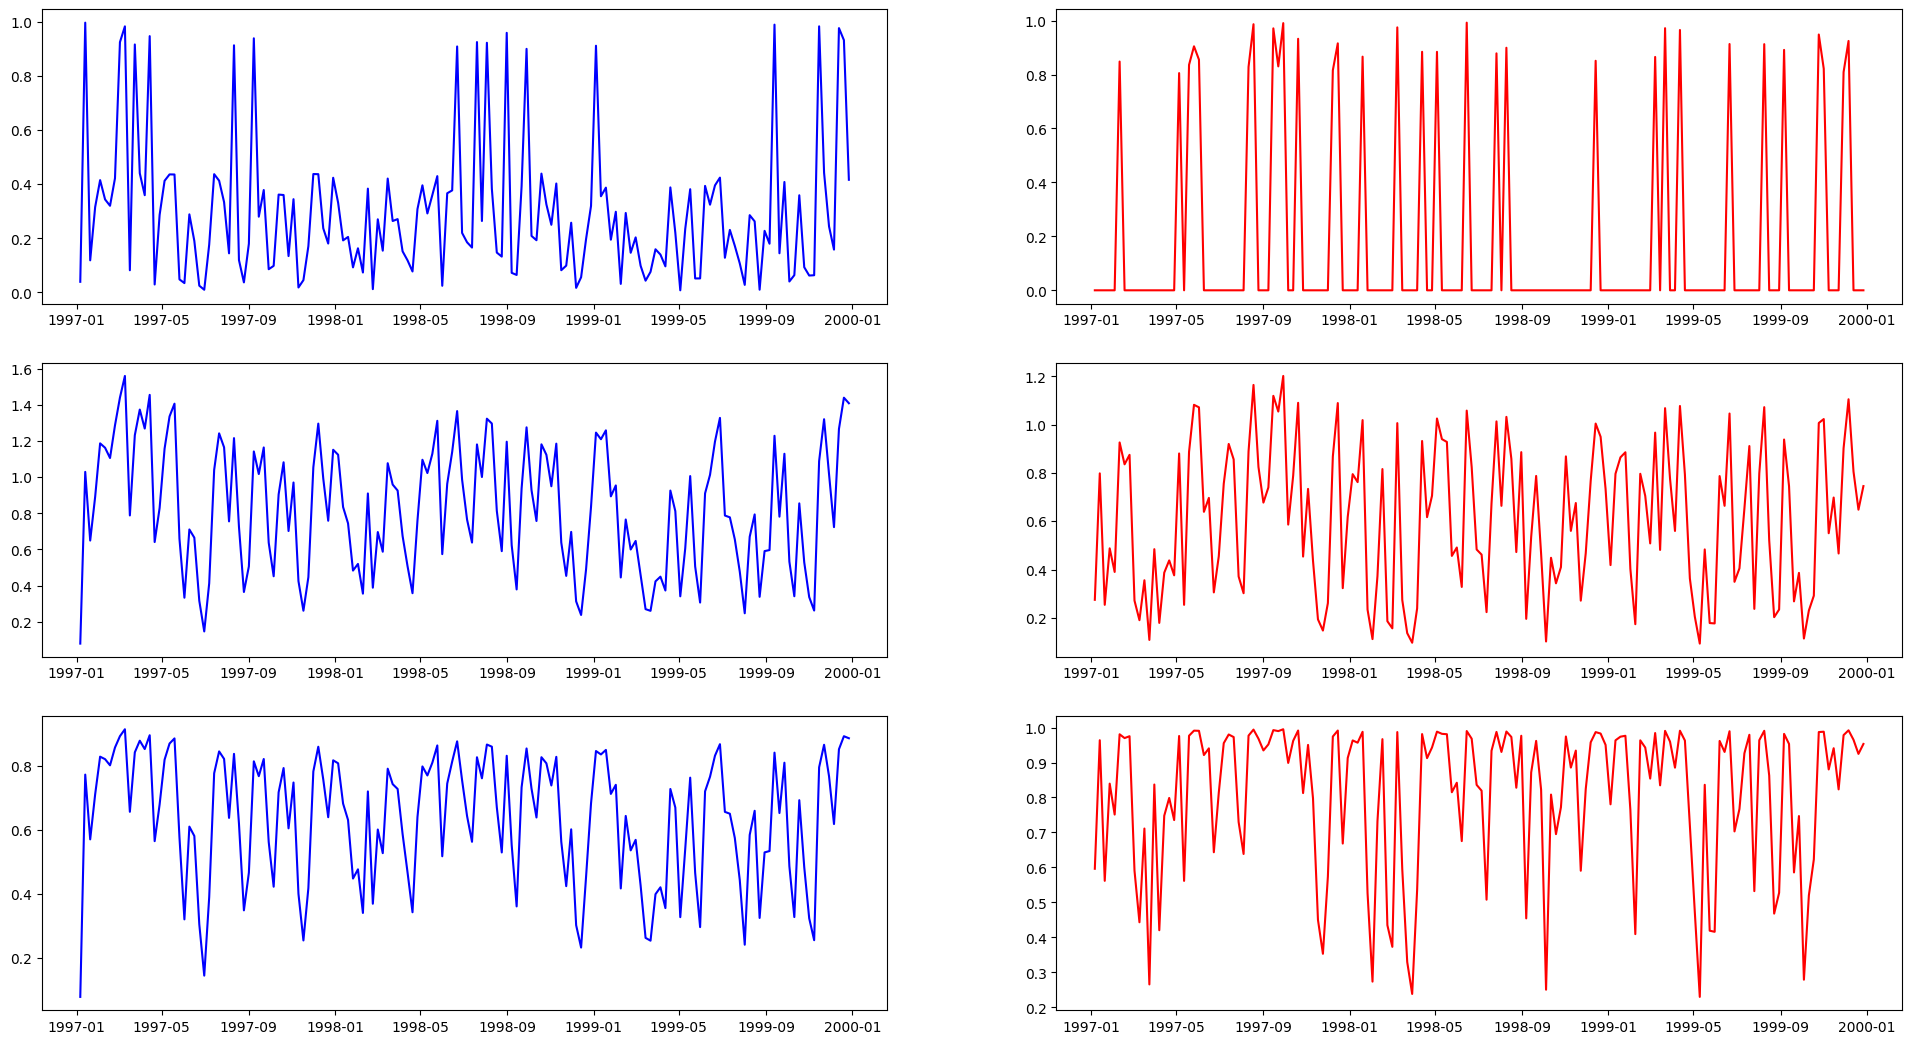

In [6]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(24,13)
)
ax[0,0].plot(df['date_week'], df['x1'], color='blue')
ax[1,0].plot(df['date_week'], df['x1_adstocked'], color='blue')
ax[2,0].plot(df['date_week'], df['x1_sat'], color='blue')
ax[0,1].plot(df['date_week'], df['x2'], color='red')
ax[1,1].plot(df['date_week'], df['x2_adstocked'], color='red')
ax[2,1].plot(df['date_week'], df['x2_sat'], color='red')

In [8]:
# we'll add one event

df['event_1'] = (df['date_week'] == "1997-06-09").astype(float)

In [9]:
# target variable

df['intercept'] = 2.0

df['epsilon'] = rng.normal(size=n)

beta_1 = 3.0
beta_2 = 2.0
beta_event = 1.5
betas = [beta_1, beta_2]

In [11]:
df['y'] = (
    df['intercept'] + 
    beta_event * df['event_1'] + 
    beta_1 * df['x1_sat'] + 
    beta_2 * df['x2_sat'] + 
    df['epsilon']
)

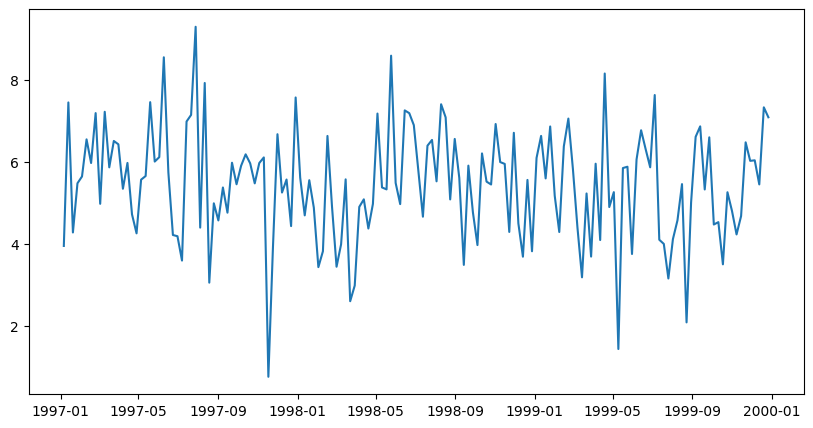

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['date_week'], df['y'])

In [14]:
coefficients = {
    'intercept': 1,
    'x1_sat': beta_1,
    'x2_sat': beta_2,
    'event_1': beta_event
    }
media_variables = ['x1_sat', 'x2_sat']
cost_dict = {
    'x1_sat': df['x1_sat_media_cost'].sum(),
    'x2_sat': df['x2_sat_media_cost'].sum()
}

# True Media Contribution

The media contribution is simply the betas over the real values of impressions/spend for all variables.

For calculating the ROI we follow

$$
ROI = \frac{\text{Incremental Contribution}}{\text{Cost}}
$$

$$

# Modeling

We will propose several ways to estimate the MMM, starting with simpler methods to more complex and advanced. However, some methods might include data processing steps.

## Frequentist Linear Regression

For estimating the linear regression we will be using the following formulas:

$$\hat{\boldsymbol{\beta}} = (X^T X)^{-1}X^TY$$
$$\text{SE}(\hat{\boldsymbol{\beta}}) = \sqrt{\text{MSE} \cdot \text{diag}((X^T X)^{-1})}$$
$$\mathbf{t} = \frac{\hat{\boldsymbol{\beta}}}{\text{SE}(\hat{\boldsymbol{\beta}})}$$
$$\mathbf{p}\text{-value} = 2 \cdot [1 - F_{T_{n-p}}(|\mathbf{t}|)]$$
where $\text{MSE} = \frac{\sum_{i=1}^n (y_i - \hat{y}i)^2}{n-p}$ and $F{T_{n-p}}(\cdot)$ is the t-distribution CDF with $n-p$ degrees of freedom.


$$F_T(x, \text{df})=
0.5 \cdot \left(1 + \text{sign}(x) \cdot \sqrt{1 - e^{-\frac{2x^2}{\pi}}}\right)$$

In [16]:
# Create and use the model
model = LinearRegression(df, 'y', ['x1_sat', 'x2_sat', 'event_1'])

# Fit the model
results = model.fit()

# Print summary
model.summary()

Linear Regression Results:
Variable        Coefficient  Std Error    t-value    p-value   
--------------------------------------------------------------------------------
x1_sat          3.585448     0.413225     8.676754   0.00e+00  
x2_sat          2.100125     0.382254     5.494052   2.26e-09  
event_1         2.974188     1.001242     2.970497   0.001819  
intercept       1.448531     0.376660     3.845723   4.07e-05  
Degrees of Freedom: 152
Number of Observations: 156


In [19]:
# Get coefficients
coefficients_estimated = model.get_coefficients()

# Addressing goodness of fit

# Model Interpretation

In [1]:
from src.data_generation import gen_data
from src.linear_regression import LinearRegression
from src.contributions import Contributions

print("Generating Data")
df = gen_data()

indep_vars = ['x1_sat', 'x2_sat', 'event_1']

lm = LinearRegression(df, 'y',indep_vars)

results = lm.fit()

lm.summary()

coefs_lm = lm.get_coefficients()

contrib_lm = Contributions(df, coefs_lm)

decomp_lm = contrib_lm.decomposition()

contrib_to_vol_lm = contrib_lm.contribution_to_volume(decomp_lm)

media_vars = ['x1_sat', 'x2_sat']

rel_contribution_to_volume_lm = contrib_lm.rel_contribution_to_volume(media_vars, contrib_to_vol_lm)

media_cost_dict = {
'x1_sat' : df['x1_sat_media_cost'].sum(),
'x2_sat' : df['x2_sat_media_cost'].sum()
}

roi_lm = contrib_lm.roi(contrib_to_vol_lm,media_vars, media_cost_dict)

Generating Data
Linear Regression Results:
Variable        Coefficient  Std Error    t-value    p-value   
--------------------------------------------------------------------------------
x1_sat          3.585448     0.413225     8.676754   0.00e+00  
x2_sat          2.100125     0.382254     5.494052   2.26e-09  
event_1         2.974188     1.001242     2.970497   0.001819  
intercept       1.448531     0.376660     3.845723   4.07e-05  
Degrees of Freedom: 152
Number of Observations: 156


In [68]:
total_execution_dict = df[media_vars].sum().to_dict()

In [53]:
from src.vizualization import Vizualization

viz = Vizualization()

(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Simple Waterfall Chart'}, ylabel='Value'>)

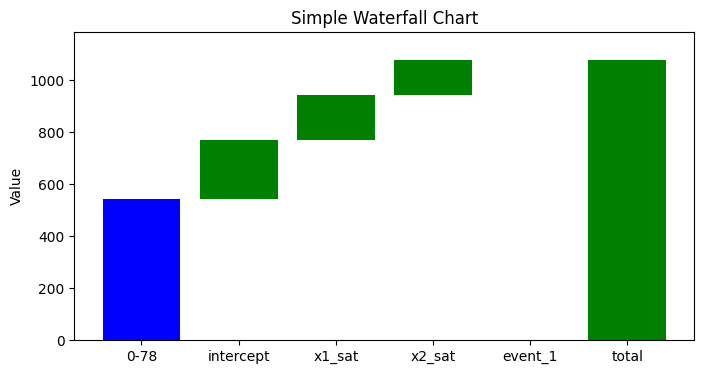

In [54]:
viz.due_to_volume(decomp_lm, 78)

In [47]:
total_list_1 = sum(series.iloc[:78].sum() for series in decomp_lm.values())
contrib_list_2 = {var: series.iloc[78:].sum() for var, series in decomp_lm.items()}

dict_test = {'0-78': total_list_1}
for var, series in contrib_list_2.items():
    dict_test[var] = series

# Sort dict_test by values
dict_test = dict(sorted(dict_test.items(), key=lambda item: item[1], reverse=True))

dict_test['total'] = sum(dict_test.values())

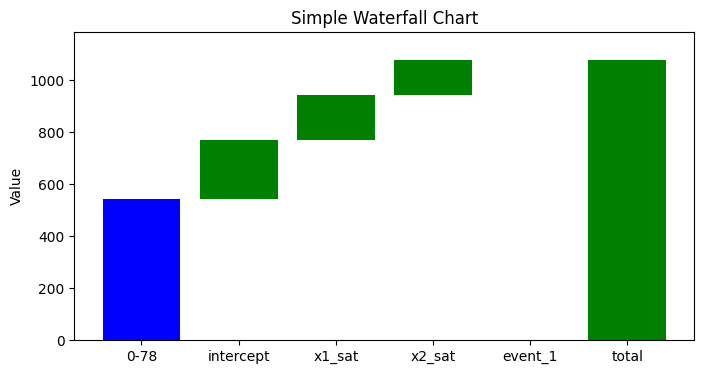

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# Convert dict values and keys to lists for indexing
values = list(dict_test.values())
labels = list(dict_test.keys())

# Calculate cumulative values for the waterfall
cumulative = [values[0]]
for v in values[1:-1]:
    cumulative.append(cumulative[-1] + v)

# Bar positions and colors
bar_positions = range(len(labels))
bar_colors = ['blue'] + ['green' if v > 0 else 'red' for v in values[1:]]

# Plot bars
ax.bar(bar_positions[0], values[0], color=bar_colors[0])
for i in range(1, len(values)-1):
    ax.bar(bar_positions[i], values[i], bottom=cumulative[i-1], color=bar_colors[i])
# Last bar (End) starts at y=0
ax.bar(bar_positions[-1], values[-1], color=bar_colors[-1])

# Add labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
ax.set_title('Simple Waterfall Chart')
ax.set_ylabel('Value')
ax.set_ylim(0, max(values)*1.1)

plt.show()
